In [1]:
import xarray as xr
import numpy as np
import glob
import os
from os import listdir
from os.path import isfile, join, isdir
import matplotlib.pyplot as plt

### File Path to Burned Area Data

In [2]:
data_path="raw/burned_area_2010_2018"

### File Path to Above Ground Biomass Data (Baseline)

In [3]:
agb_data = xr.open_dataset("preprocess/agb_avitabile_2010-2016_v3.nc")

### Loading and Merging the files

In [4]:
#Function to get all file names
def _get_file_list(root):
    files = [join(root, f) for f in listdir(root) if isfile(join(root, f)) and f.endswith(".nc")]
    dirs = [d for d in listdir(root) if isdir(join(root, d))]
    return files
list_files = sorted(_get_file_list(data_path))  #List of data file paths
burned_area_data = xr.open_mfdataset(paths=list_files, parallel=True)

In [5]:
print(burned_area_data)

<xarray.Dataset>
Dimensions:                          (lat: 720, lon: 1440, nv: 2, time: 108, vegetation_class: 18)
Coordinates:
  * lat                              (lat) float32 89.88 89.62 ... -89.62 -89.88
  * lon                              (lon) float32 -179.9 -179.6 ... 179.6 179.9
  * time                             (time) datetime64[ns] 2010-01-01 ... 201...
  * vegetation_class                 (vegetation_class) int32 10 20 ... 170 180
Dimensions without coordinates: nv
Data variables:
    lat_bnds                         (time, lat, nv) float32 dask.array<chunksize=(1, 720, 2), meta=np.ndarray>
    lon_bnds                         (time, lon, nv) float32 dask.array<chunksize=(1, 1440, 2), meta=np.ndarray>
    time_bnds                        (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    vegetation_class_name            (time, vegetation_class) |S150 dask.array<chunksize=(1, 18), meta=np.ndarray>
    burned_area                      (time, lat,

### Dropping Unwanted Features, Coordinates and rename

In [6]:
burned_area_data = burned_area_data.drop(["vegetation_class","lat_bnds","lon_bnds","time_bnds","vegetation_class_name","standard_error","fraction_of_observed_area","number_of_patches","burned_area_in_vegetation_class"])

In [7]:
burned_area_data = burned_area_data.rename({"lon":"longitude","lat":"latitude"})

### Slicing data from 2010-16

In [8]:
burned_area_data = burned_area_data.sel(time=slice(burned_area_data.time.values[0], burned_area_data.time.values[83]))

### Interpolating Data to match resolution of AGB

In [9]:
burned_area_data = burned_area_data.interp({'latitude':burned_area_data.latitude.values,'longitude':burned_area_data.longitude.values})

In [10]:
fraction_burnable_area_data = burned_area_data.drop(["burned_area"])
burned_area_data = burned_area_data.drop(["fraction_of_burnable_area"])

In [11]:
print(burned_area_data)

<xarray.Dataset>
Dimensions:      (latitude: 720, longitude: 1440, time: 84)
Coordinates:
  * time         (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2016-12-01
  * latitude     (latitude) float32 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
  * longitude    (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    burned_area  (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/40)
    title:                      Fire_cci Gridded MODIS Burned Area product
    institution:                University of Alcala
    source:                     MODIS MOD09GQ Collection 6, MODIS MOD09GA Col...
    history:                    Created on 2018-12-02 00:08:23
    references:                 See www.esa-fire-cci.org
    tracking_id:                d881ff6e-9892-45d7-9b9c-85e92cd4ddac
    ...                         ...
    sensor:                     MODIS
    spatial_resolution:         0.25 degrees
    geospatial_

In [12]:
print(fraction_burnable_area_data)

<xarray.Dataset>
Dimensions:                    (latitude: 720, longitude: 1440, time: 84)
Coordinates:
  * time                       (time) datetime64[ns] 2010-01-01 ... 2016-12-01
  * latitude                   (latitude) float32 89.88 89.62 ... -89.62 -89.88
  * longitude                  (longitude) float32 -179.9 -179.6 ... 179.6 179.9
Data variables:
    fraction_of_burnable_area  (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/40)
    title:                      Fire_cci Gridded MODIS Burned Area product
    institution:                University of Alcala
    source:                     MODIS MOD09GQ Collection 6, MODIS MOD09GA Col...
    history:                    Created on 2018-12-02 00:08:23
    references:                 See www.esa-fire-cci.org
    tracking_id:                d881ff6e-9892-45d7-9b9c-85e92cd4ddac
    ...                         ...
    sensor:                     MODIS
    spatial_resolution:    

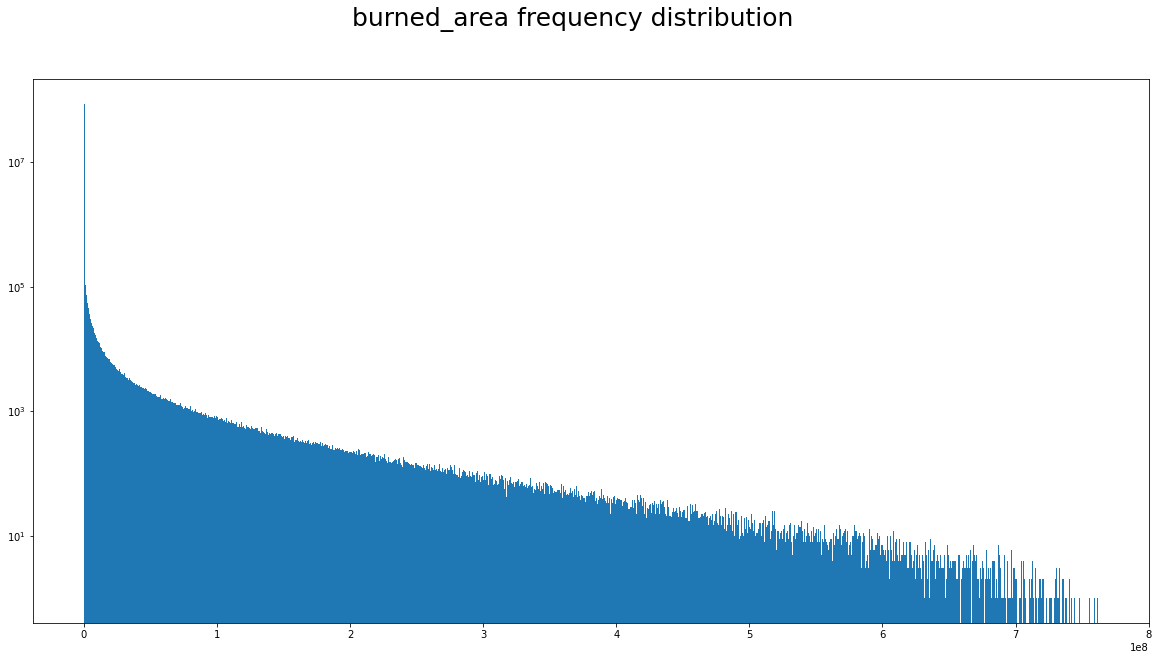

In [13]:
var_list =['burned_area']
for i in range(len(var_list)):
    plt.figure(figsize = (20,10)).suptitle(f'{var_list[i]} frequency distribution', fontsize=25)
    plt.hist(burned_area_data[var_list[i]].values.flatten(), bins=1000, cumulative=False, log=True)

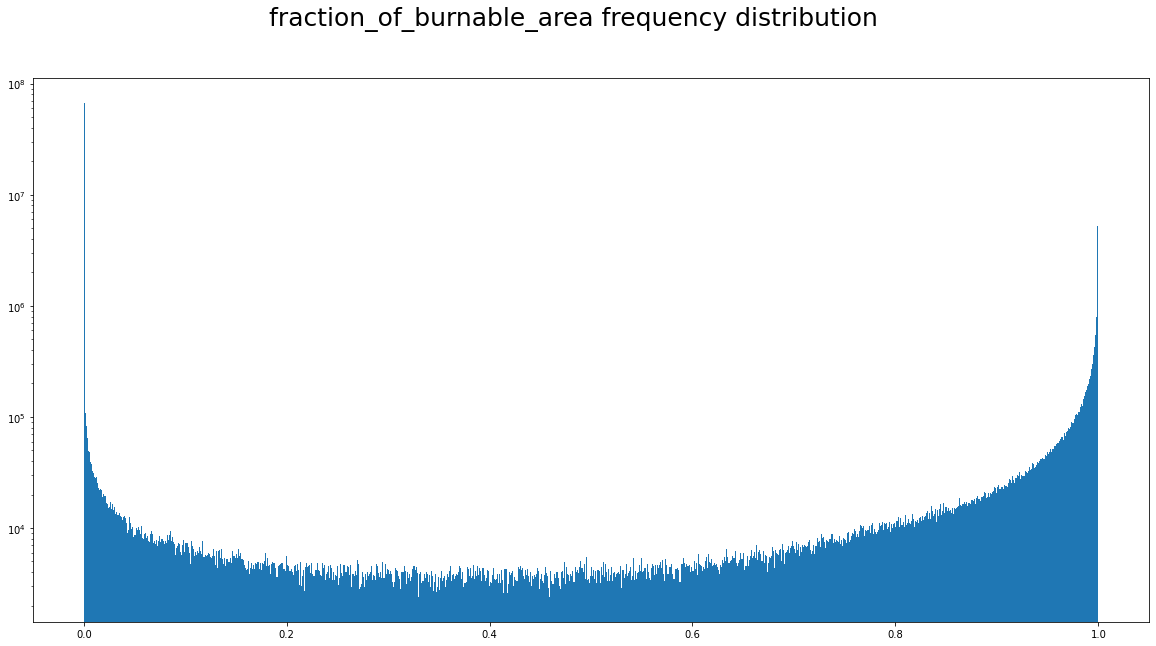

In [14]:
var_list =['fraction_of_burnable_area']
for i in range(len(var_list)):
    plt.figure(figsize = (20,10)).suptitle(f'{var_list[i]} frequency distribution', fontsize=25)
    plt.hist(fraction_burnable_area_data[var_list[i]].values.flatten(), bins=1000, cumulative=False, log=True)

### Saving Data

In [15]:
burned_area_data.to_netcdf("preprocess/ba_2010-2016_v3.nc")
fraction_burnable_area_data.to_netcdf("preprocess/ba_fraction_2010-2016_v3.nc")

### Sanity Check

In [16]:
print(burned_area_data.to_dataframe().describe())

        burned_area
count  8.709120e+07
mean   3.636585e+05
std    7.676492e+06
min    0.000000e+00
25%    0.000000e+00
50%    0.000000e+00
75%    0.000000e+00
max    7.620383e+08


In [17]:
print(fraction_burnable_area_data.to_dataframe().describe())

       fraction_of_burnable_area
count               8.709120e+07
mean                1.892401e-01
std                 3.747084e-01
min                 0.000000e+00
25%                 0.000000e+00
50%                 0.000000e+00
75%                 0.000000e+00
max                 1.000000e+00


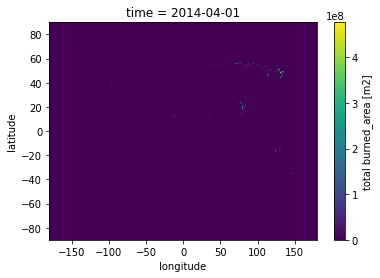

In [18]:
random_date = "201" + str(np.random.randint(0,6)) + "-" + str(np.random.randint(1, 12)) + "-01T00:00:00.000000000"
burned_area_data.sel(time=random_date).burned_area.plot()

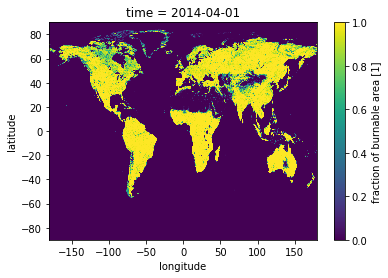

In [19]:
fraction_burnable_area_data.sel(time=random_date).fraction_of_burnable_area.plot()

## FIle Size in MB

### Burned Area

In [20]:
round(os.stat("preprocess/ba_2010-2016_v3.nc").st_size / (1024 * 1024), 3)

332.255

### Fraction of Burnable Area

In [21]:
round(os.stat("preprocess/ba_fraction_2010-2016_v3.nc").st_size / (1024 * 1024), 3)

332.254